In [44]:
import math
import itertools
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.ticker import ScalarFormatter

import seaborn as sns

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

from datetime import datetime

SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines',markerfacecolor='w')


def find_nearest(value,df):
    exactmatch = df[df.index==value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbor_ind = df[df.index<value].idxmin()
        upperneighbor_ind = df[df.index>value].idxmax()
    lower_diff = abs(lowerneighbor_ind - value)
    upper_diff = abs(lowerneighbor_ind - value)
    if lower_diff < upper_diff:
        nearest = lowerneighbor_ind
    else:
        nearest = upperneighbor_ind
    return nearest

# Load observed soils data

In [47]:
# load pfas data
file = '../data/_archive/LF_data_archive.xlsx'#'./LF_data_archive.xlsx'
pfas = pd.read_excel(file,
                    sheet_name='pfas_for_python',na_values='N.D.')
pfas.iloc[:,1:] = pfas.iloc[:,1:]*1000 # convert ng/g to ng/kg

# load soils data
samples = pd.read_excel(file,sheet_name='soil_props_for_python')
texture = pd.read_excel(file,sheet_name='soil_texture_for_python')
samples = pd.merge(samples,texture, on='sample')

# load TOC data
toc = pd.read_excel(file,sheet_name='toc_for_python')
toc['foc'] = toc.toc/100

# merge all data
merged = pd.merge(samples, pfas, on='sample')
merged = pd.merge(merged, toc, on='sample')

merged.drop(['depth_ft'], axis=1, inplace=True)
merged.porosity = merged.porosity/100

# take out core A because it didn't receive irrigation
merged.drop(merged[merged['core'] == 'A'].index,inplace=True)
merged.sort_values('depth_m',inplace=True)

water_pfas = pd.read_excel(file,
                        sheet_name='gw_pfas_for_python',
                        na_values='N.D.')

pd.to_numeric(water_pfas['ng_L'])
water_pfas['kind'] = ['eff' if x == 'eff' else 'gw' for x in water_pfas['well']]
water_stats = water_pfas.groupby(['kind','compound']).describe()
gw_stats = water_stats.loc['gw','ng_L']
eff_stats = water_stats.loc['eff','ng_L']


# Define non-uniform model elements

- Define element sizes by fitting power law to porosity data and integrating.
- find centers of those elements
- calculate the soil mass in each element using power law fit to bulk density data
- fit power law to TOC data and use centers to define the TOC for each element

## define elements

### fit curve to porosity

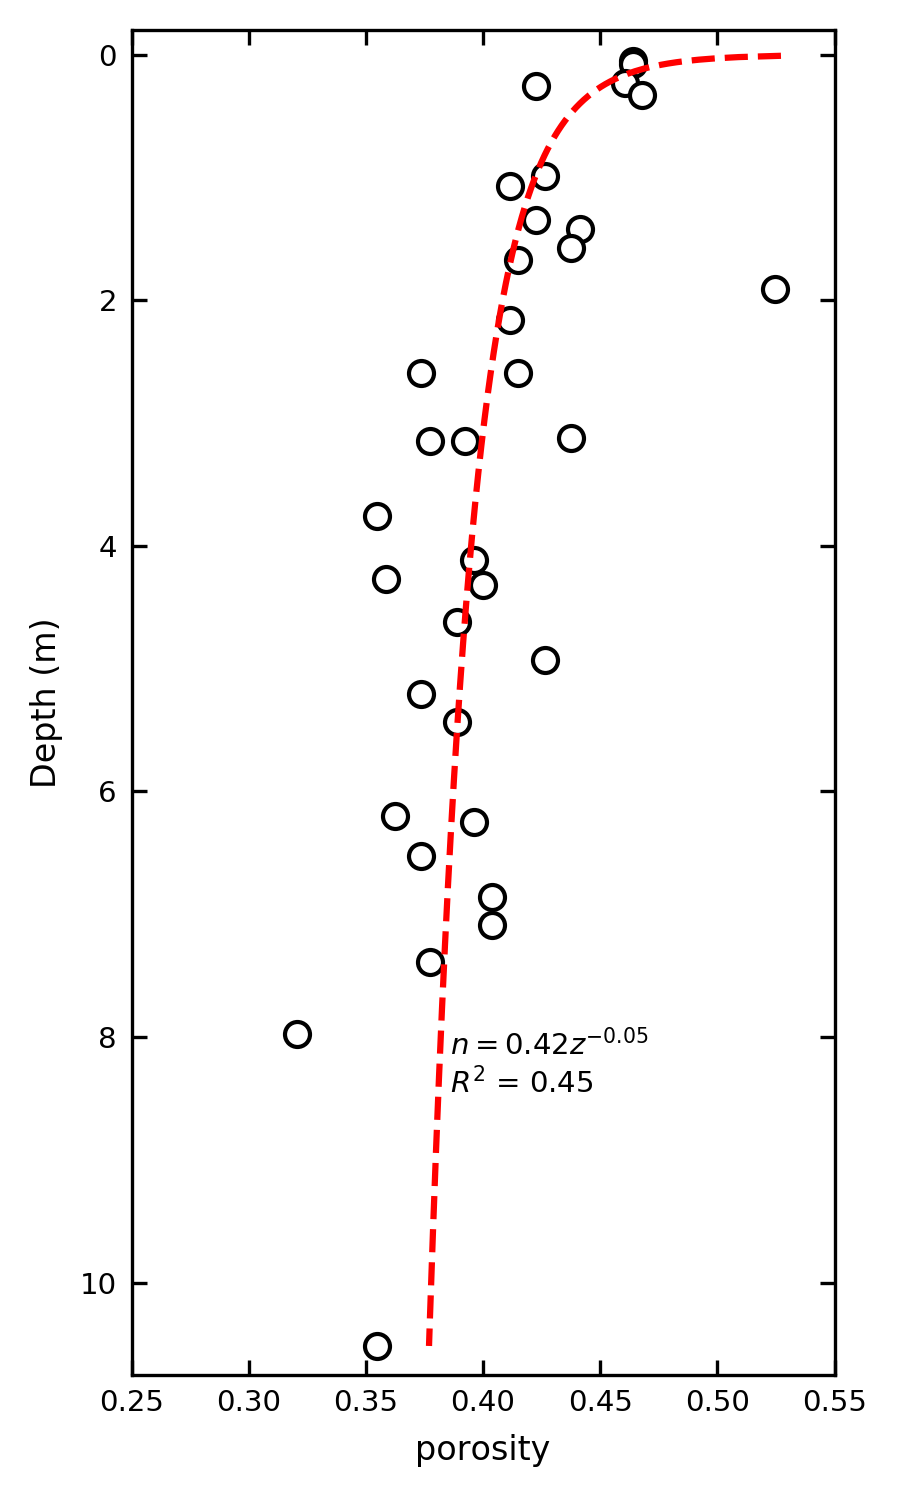

In [4]:
# power law
def f(x, N, a):
    return N * x ** (a)

xData = merged.depth_m.values
yData = merged.porosity.values

# optimize using the appropriate bounds
popt, pcov = curve_fit(f, xData, yData,)
residuals = yData - f(xData, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yData-np.mean(yData))**2)
r_squared = 1 - (ss_res / ss_tot)

xnew = np.linspace(0.01, max(xData), 1000)
N = popt[0]
a = popt[1]
                   
# plot the data
fig,ax = plt.subplots(figsize=(3,5),dpi=300);
ax.plot(yData, xData, 'ko')
ax.plot(f(xnew, *popt), xnew, 'r--')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('porosity')
ax.set_ylim(10.75,-0.2)
ax.tick_params(direction='in',right=True, top=True)
ax.set_xlim(0.25,0.55)
# ax.set_xticks(np.arange(0.3))

# power
ax.annotate('$n = {{{N}}}z^{{{a}}}$\n$R^2$ = {r}'
            .format(N=round(N,2),a=round(a,2),r=round(r_squared,2)),xy=(f(8.5, *popt)+0.005,8.5),va='bottom');

fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig(r'C:\Users\Kalle\Box Sync\Living_filter\figures\por_model.png')

### determine element bounds

In [5]:
# use the integrated function to determine element sizes

A = 1+a
B = N/A
# set depth of first element
d1 = 0.06 # meters
# find volume of first element
V = ((B * d1 ** A) - (B * 0 ** A)) # desired element volume m3

# create depths list
depths = [0]
# add the first element depth
depths.append(d1)

for i in range(2,2000):
    z0 = depths[i-1] # the previous depth
    z1 = ((V/B) + (z0 ** A)) ** (1/A)# the next depth
#     if z1 < 10.6:
    if z1 < 50.1: # decide how deep you want model domain to be
        depths.append(z1)
    else:
        print('last depth = {}, {} elements'.format(round(depths[i-1],4),len(depths)))
        break
# depths = depths+list(np.arange(depths[-1],50,(depths[-1]-depths[-2])))

last depth = 50.032, 604 elements


## determine element centers

In [6]:
# calculate the center of each element
centers = []
focs = []
for i in range(len(depths)-1):
    center = depths[i] + ((depths[i+1] - depths[i])/2)
    centers.append(center)


## Calculate soil masses for elements, fit curve to bulk density

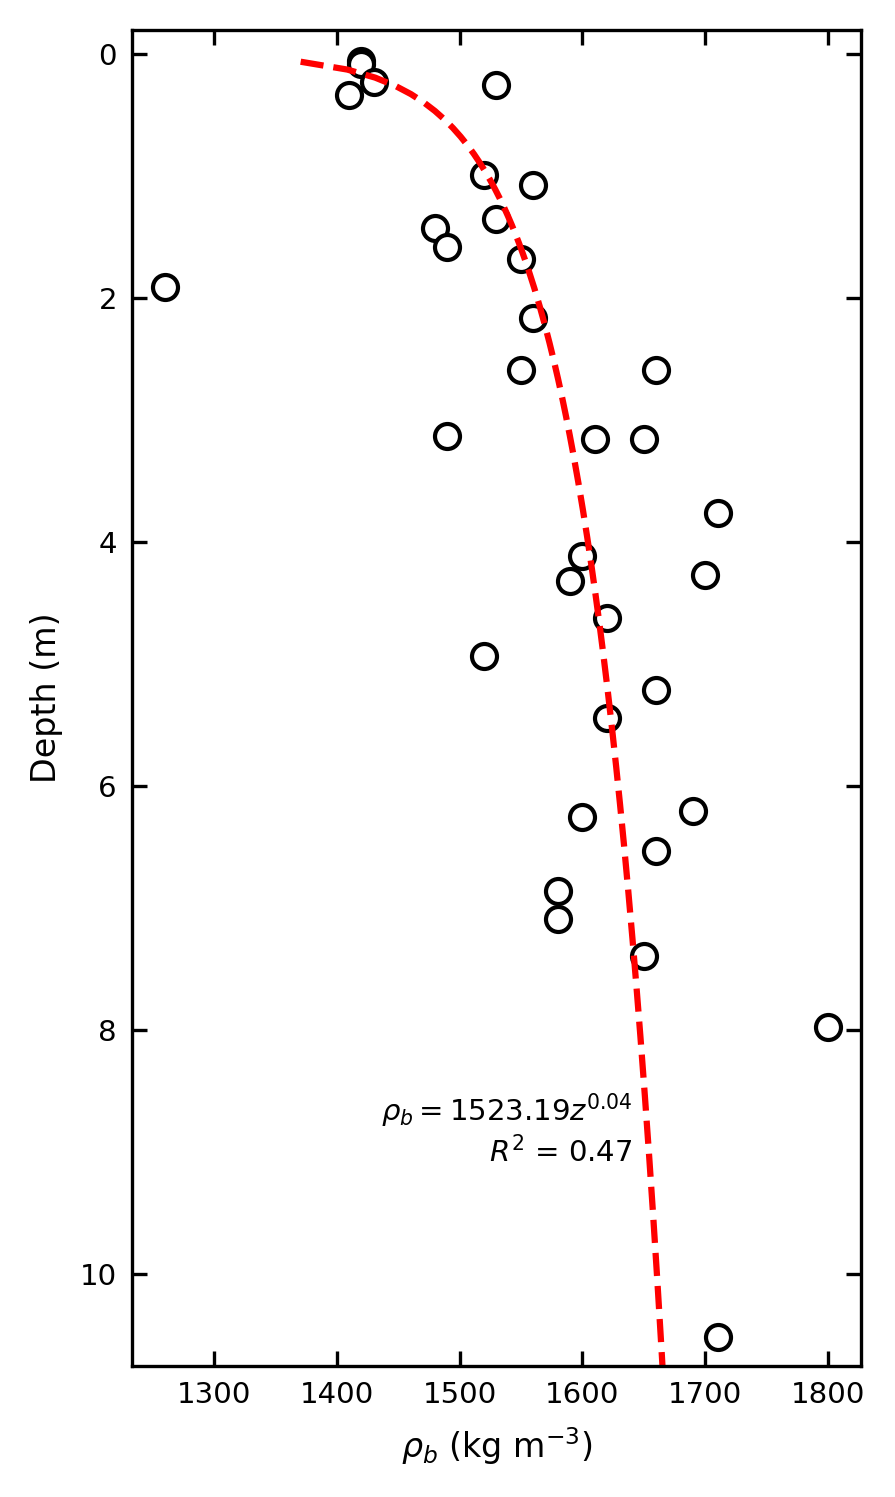

In [7]:
# power law
def f(x, Nm, am):
    return Nm * x ** (am)

# exponential
# def f(x, Nm, am):
#     return Nm * np.exp(am * x)
# linear
# def f(x, Nm, am):
#     return Nm * x + am

xData = merged.depth_m.values
yData = merged.dry_bulk_density.values * 1000 # kg/m3 soil

# optimize using the appropriate bounds
popt, pcov = curve_fit(f, xData, yData)
residuals = yData - f(xData, *popt)
Nm = popt[0]
am = popt[1]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yData-np.mean(yData))**2)
r_squared = 1 - (ss_res / ss_tot)

xnew = np.linspace(0.01, max(xData), 1000)
                   
# plot the data
fig,ax = plt.subplots(figsize=(3,5),dpi=300)
ax.plot(yData, xData, 'ko')
ax.plot(f(depths[1:], *popt), depths[1:], 'r--')

# power
ax.annotate('$ρ_b = {{{Nm}}}z^{{{am}}}$\n$R^2$ = {r}'
            .format(Nm=round(Nm,2),am=round(am,2),r=round(r_squared,2)),
            xy=(f(8.5, *popt)-10,8.5),va='top',ha='right');

ax.set_ylim(10.75,-0.2)
ax.set_xlabel('$ρ_b$ (kg m$^{-3}$)')
ax.set_ylabel('Depth (m)')
ax.tick_params(direction='in',right=True, top=True)
# exponential
# ax.annotate('$\rho = {{{Nm}}}z+{{{a}}}$\n$R^2$ = {r}'.format(Nm=Nm,a=a,r=round(r_squared,2)),
#                xy=(8,f(8, *popt)),va='bottom');
# linear
# ax.annotate('$n = {{{Nm}}}z+{{{a}}}$\n$R^2$ = {r}'.format(Nm=Nm,a=a,r=round(r_squared,2)),
#                xy=(8,f(8, *popt)),va='bottom');


# CALCULATE MASSES USING INTERGRATION
Am = 1+am
Bm = Nm/Am

soil_masses = []

# find masses of the elements
for i in range(0,len(depths)-1):
    z0 = depths[i]
    z1 = depths[i+1]
#     Mnew = 
    M = ((Bm * z1 ** Am) - (Bm * z0 ** Am)) # mass from the integration
    soil_masses.append(M)

fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig(r'C:\Users\Kalle\Box Sync\Living_filter\figures\bulk_model.png')

## Calculate element foc values using centers and power law fit to foc data

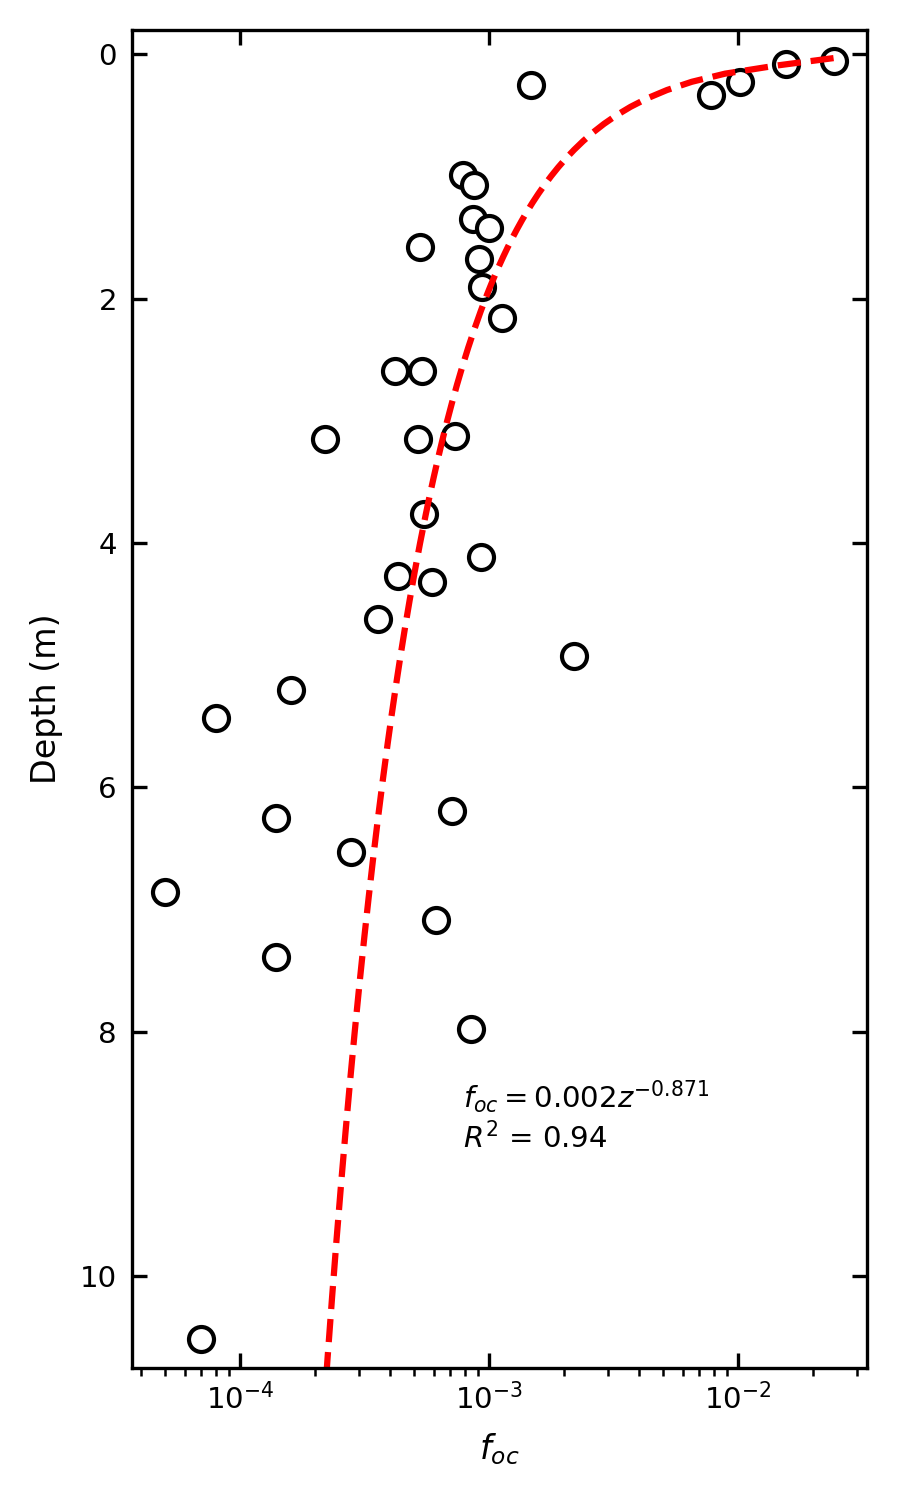

In [8]:
# power law
def f(x, N, a):
    return N * x ** (a)

xData = merged.depth_m.values
yData = merged.foc.values

# optimize using the appropriate bounds
popt, pcov = curve_fit(f, xData, yData)
residuals = yData - f(xData, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yData-np.mean(yData))**2)
r_squared = 1 - (ss_res / ss_tot)

xnew = np.linspace(0.01, max(xData), 1000)
N = popt[0]
a = popt[1]
                   
# plot the data
fig, ax = plt.subplots(figsize=(3,5),dpi=300)

ax.plot(yData,xData, 'ko')
# ax = sns.scatterplot(x='foc',y='depth_m',data=merged,hue='core',style='core',
#                     palette=['#8D2A81','#DF5a69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
#                     markers=['o','^','d'],alpha=.8,
#                     ax=ax,zorder=1)
# ax.plot(f(depths[1:], *popt), depths[1:], 'r--')
ax.set_ylim(10.75,-0.2)
ax.set_xscale('log')

# assign each element an Foc value
focs = f(centers, *popt)
# swap out the first fit value with an actual value to eliminate the high tail
# that sticks out beyond what has been observed
focs[0] = merged.foc.values[0]
focs0 = focs.copy()
# setting focs lower below a certain depth, meant to represent shift to bedrock with low toc...
depth = 30
idx = np.searchsorted(centers, depth, side="left")
focs0[idx:] = 0
ax.plot(focs,centers,'--',color='r')

# exponential
ax.annotate('$f_{{oc}}= {{{N}}}z^{{{a}}}$\n$R^2$ = {r}'
            .format(N=round(N,3),a=round(a,3),r=round(r_squared,2)),
            xy=(f(8, *popt)+0.0005,9),va='bottom');
ax.set_xlabel('$f_{oc}$')
ax.set_ylabel('Depth (m)')
ax.tick_params(direction='in',right=True, top=True)
fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig(r'C:\Users\Kalle\Box Sync\Living_filter\figures\foc_model.png')

# Define PFAA mass flux bucket model

## original version

In [9]:
def bucket(sol_mass_in, kd, soil_masses,pfas):
    # matrices for storing the previous step
    sol_old = np.zeros(len(centers)) # solution mass (ng)
    ads_old = np.zeros(len(centers)) # adsorbed (ng)
    # tot_old = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    # matrices for storing the new step
    sol_new = np.zeros(len(centers)) # solution mass (ng)
    ads_new = np.zeros(len(centers)) # adsorbed (ng)
    # tot_new = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    sol_df = pd.DataFrame(index=centers)
    ads_df = pd.DataFrame(index=centers)

    # set up the first element 
    sol_old[0] = sol_mass_in[0]
    tot = sol_old[0] + ads_old[0] # calculate total mass for equilibration
    kd_temp = kd[0] * (soil_masses[0]/(V*1000)) # unitless for use with masses
    ads_old[0] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
    sol_old[0] = tot - ads_old[0] # assigning the solute portion

    for j in range(len(sol_mass_in)):
    # For each step, add new mass to the first element of sol_new
        sol_new[0] = sol_mass_in[j]
    # then move all the solution masses down one element
        sol_new[1:] = sol_old[:-1].copy()
        out = sol_old[-1:].copy()
    # then go through each element to calculate new ads and sol matrices...
        for i in range(len(centers)):
            tot = sol_new[i] + ads_old[i] # need to calculate equilibration
            kd_temp = kd[i] * (soil_masses[i]/(V*1000)) # unitless for use with masses
            ads_new[i] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
            sol_new[i] = tot - ads_new[i] # assigning the solute portion
        # calculate concentrations from the masses
#         print('sol_new contains only floats: ', np.isfinite(sol_new).all())
        sol_df[j+1] = sol_new / (V*1000) # ng/m3
        ads_df[j+1] = ads_new / soil_masses # ng/Kg
        
#         if np.array_equal(ads_new.round(2), ads_old.round(2)):
#             break # stop the simulation if the arrays have not changed 
#         else:
#             # reset the matrices to go again
        sol_old = sol_new.copy()
        ads_old = ads_new.copy()

    ads_df_ngg = ads_df / 1000 # convert from ng/kg to ng/g

    sol_df_ngL = sol_df / 1000 # convert from ng/m3 to ng/L

    # calculate RMSE for 2014
    mod = ads_df.iloc[:,50*52] # 1964 to 2014 = 50 years
    obs = merged.set_index('depth_m').loc[:,pfas].dropna()
    obs.sort_index(inplace=True)
    # model and observed depths don't match
    # so need to find closest matches...
    shared = []
    for i in obs.index:
        shared.append(find_nearest(i,mod))

    modeled = mod[shared].values
    observed = obs.values
    weights = [10 if x < 2. else 1 for x in shared]
    # RMSE
    rmse = np.sqrt(mean_squared_error(observed, modeled,
                                      sample_weight=weights
                                     )
                  )
    return ads_df, sol_df, rmse

## version with faster timestep

In [10]:
def bucket_day(sol_mass_in, kd, soil_masses, pfas):
    # matrices for storing the previous step
    sol_old = np.zeros(len(centers)) # solution mass (ng)
    ads_old = np.zeros(len(centers)) # adsorbed (ng)
    # tot_old = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    # matrices for storing the new step
    sol_new = np.zeros(len(centers)) # solution mass (ng)
    ads_new = np.zeros(len(centers)) # adsorbed (ng)
    # tot_new = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    sol_df = pd.DataFrame(index=centers)
    ads_df = pd.DataFrame(index=centers)

    # set up the first element 
    sol_old[0] = sol_mass_in[0]
    tot = sol_old[0] + ads_old[0] # calculate total mass for equilibration
    kd_temp = kd[0] * (soil_masses[0]/(V*1000)) # unitless for use with masses
    ads_old[0] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
    sol_old[0] = tot - ads_old[0] # assigning the solute portion

    for j in range(len(sol_mass_in)):
    # For each step, add new mass to the first element of sol_new
        sol_new[0] = sol_mass_in[j]
    # then move all the solution masses down one element
        sol_new[1:] = sol_old[:-1].copy()
        out = sol_old[-1:].copy()
    # then go through each element to calculate new ads and sol matrices...
        for i in range(len(centers)):
            # check to see if the solution has pfas in it
            if sol_new[i] != False:
            # if it does, do equlibration.
                tot = sol_new[i] + ads_old[i] # need to calculate equilibration
                kd_temp = kd[i] * (soil_masses[i]/(V*1000)) # unitless for use with masses
                ads_new[i] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
                sol_new[i] = tot - ads_new[i] # assigning the solute portion
        # calculate concentrations from the masses
#         print(sol_new[1])
        sol_df[j+1] = sol_new / (V*1000) # ng/L
        ads_df[j+1] = ads_new / soil_masses # ng/Kg
        
        sol_old = sol_new.copy()
        ads_old = ads_new.copy()

#     # calculate RMSE
#     mod = ads_df.iloc[:,-1]
#     obs = merged.set_index('depth_m').loc[:,pfas].dropna()
#     obs.sort_index(inplace=True)
#     # model and observed depths don't match
#     # so need to find closest matchest...
#     shared = []
#     for i in obs.index:
#         shared.append(find_nearest(i,mod))

#     modeled = mod[shared].values
#     observed = obs.values
#     weights = [10 if x < 1. else 1 for x in shared]
#     # RMSE
#     rmse = np.sqrt(mean_squared_error(observed, modeled))
    return ads_df, sol_df #rmse

# PFOS

## Run parameter sweep

In [ ]:
run = False
if run:
    pfaa = 'PFOS'
    con_mean = eff_stats.loc[pfaa,'mean']

    logkoc_range = [x for x in np.arange(2.4,3.9,.05)]
    con_range = list(np.arange(10.,510.,10.))
    # 0 in pairs is logkoc and 1 is input concentration
    pairs = list(itertools.product(logkoc_range, con_range))
    keys = ['{:.2f}_{:.0f}'.format(p[0],p[1]) for p in pairs]

    bot_dict = {}
    thi_dict = {}
    rms_list = []

    for p, k in zip(pairs,keys):
        koc = 10**p[0]
        kd = focs * koc
        # set the runt time by setting sol_mass_in, adjusting the amount of time for all the parts
    #     sol_mass_in = [p[1] * V * 1000]*37*52 \ # initial concentration
    #                 + list(np.linspace(p[1] * V * 1000,con_mean * V * 1000,14*52)) \ # Linear decrease from 2000-2014
    #                 + [con_mean * V * 1000]*69*52 # 2020 effluent,

        initial = [p[1] * V * 1000]*37*52 # initial concentration
        mid = list(np.linspace(p[1] * V * 1000,con_mean * V * 1000,14*52)) # Linear decrease from 2000-2014
        final = [con_mean * V * 1000]*69*52 # 2020 effluent concentration
        sol_mass_in = initial + mid + final # 37 + 17 + 69 for 1964 -> 2084

        ads, sol, rms = bucket(sol_mass_in,kd,soil_masses,pfaa)

        thi_dict[k] = sol.iloc[370,:].values
        bot_dict[k] = sol.iloc[-1,:].values

        # save pared down versions of the output
        ads.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfos_sweep/ads6/'+k+'.csv')
        sol.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfos_sweep/sol6/'+k+'.csv')

        rms_list.append([k,p[0],p[1],rms])

        print(k, datetime.now())

    bottom_df = pd.DataFrame(bot_dict)
    bottom_df.to_csv('./pfos_sweep/bottom_v6.csv')
    thirty_df = pd.DataFrame(thi_dict)
    thirty_df.to_csv('./pfos_sweep/thirty_v6.csv')

    rms_df = pd.DataFrame(rms_list,columns = ['key','logKoc','con_in','rms'])
    rms_df.to_csv('./pfos_sweep/rms_v6.csv')

    del bottom_df, thirty_df, rms_df, bot_dict, thi_dict, rms_list

## Retrieve data from csv files if sweep has been run in past

In [11]:
ads_dict5s = {}
sol_dict5s = {}

for csv in os.listdir('./pfos_sweep/ads6'):
    key = os.path.splitext(csv)[0]
    a = pd.read_csv('./pfos_sweep/ads6/'+csv,index_col='Unnamed: 0')
    a.columns = [int(x) for x in a.columns.values]
    s = pd.read_csv('./pfos_sweep/sol6/'+csv,index_col='Unnamed: 0')
    s.columns = [int(x) for x in s.columns.values]
    ads_dict5s[key] = a
    sol_dict5s[key] = s

bottom_df = pd.read_csv('./pfos_sweep/bottom_v6.csv')
thirty_df = pd.read_csv('./pfos_sweep/thirty_v6.csv')
rms_df = pd.read_csv('./pfos_sweep/rms_v6.csv')
rms_df.sort_values('key',inplace=True)
rms_df.set_index('key',inplace=True)

## Heatmap

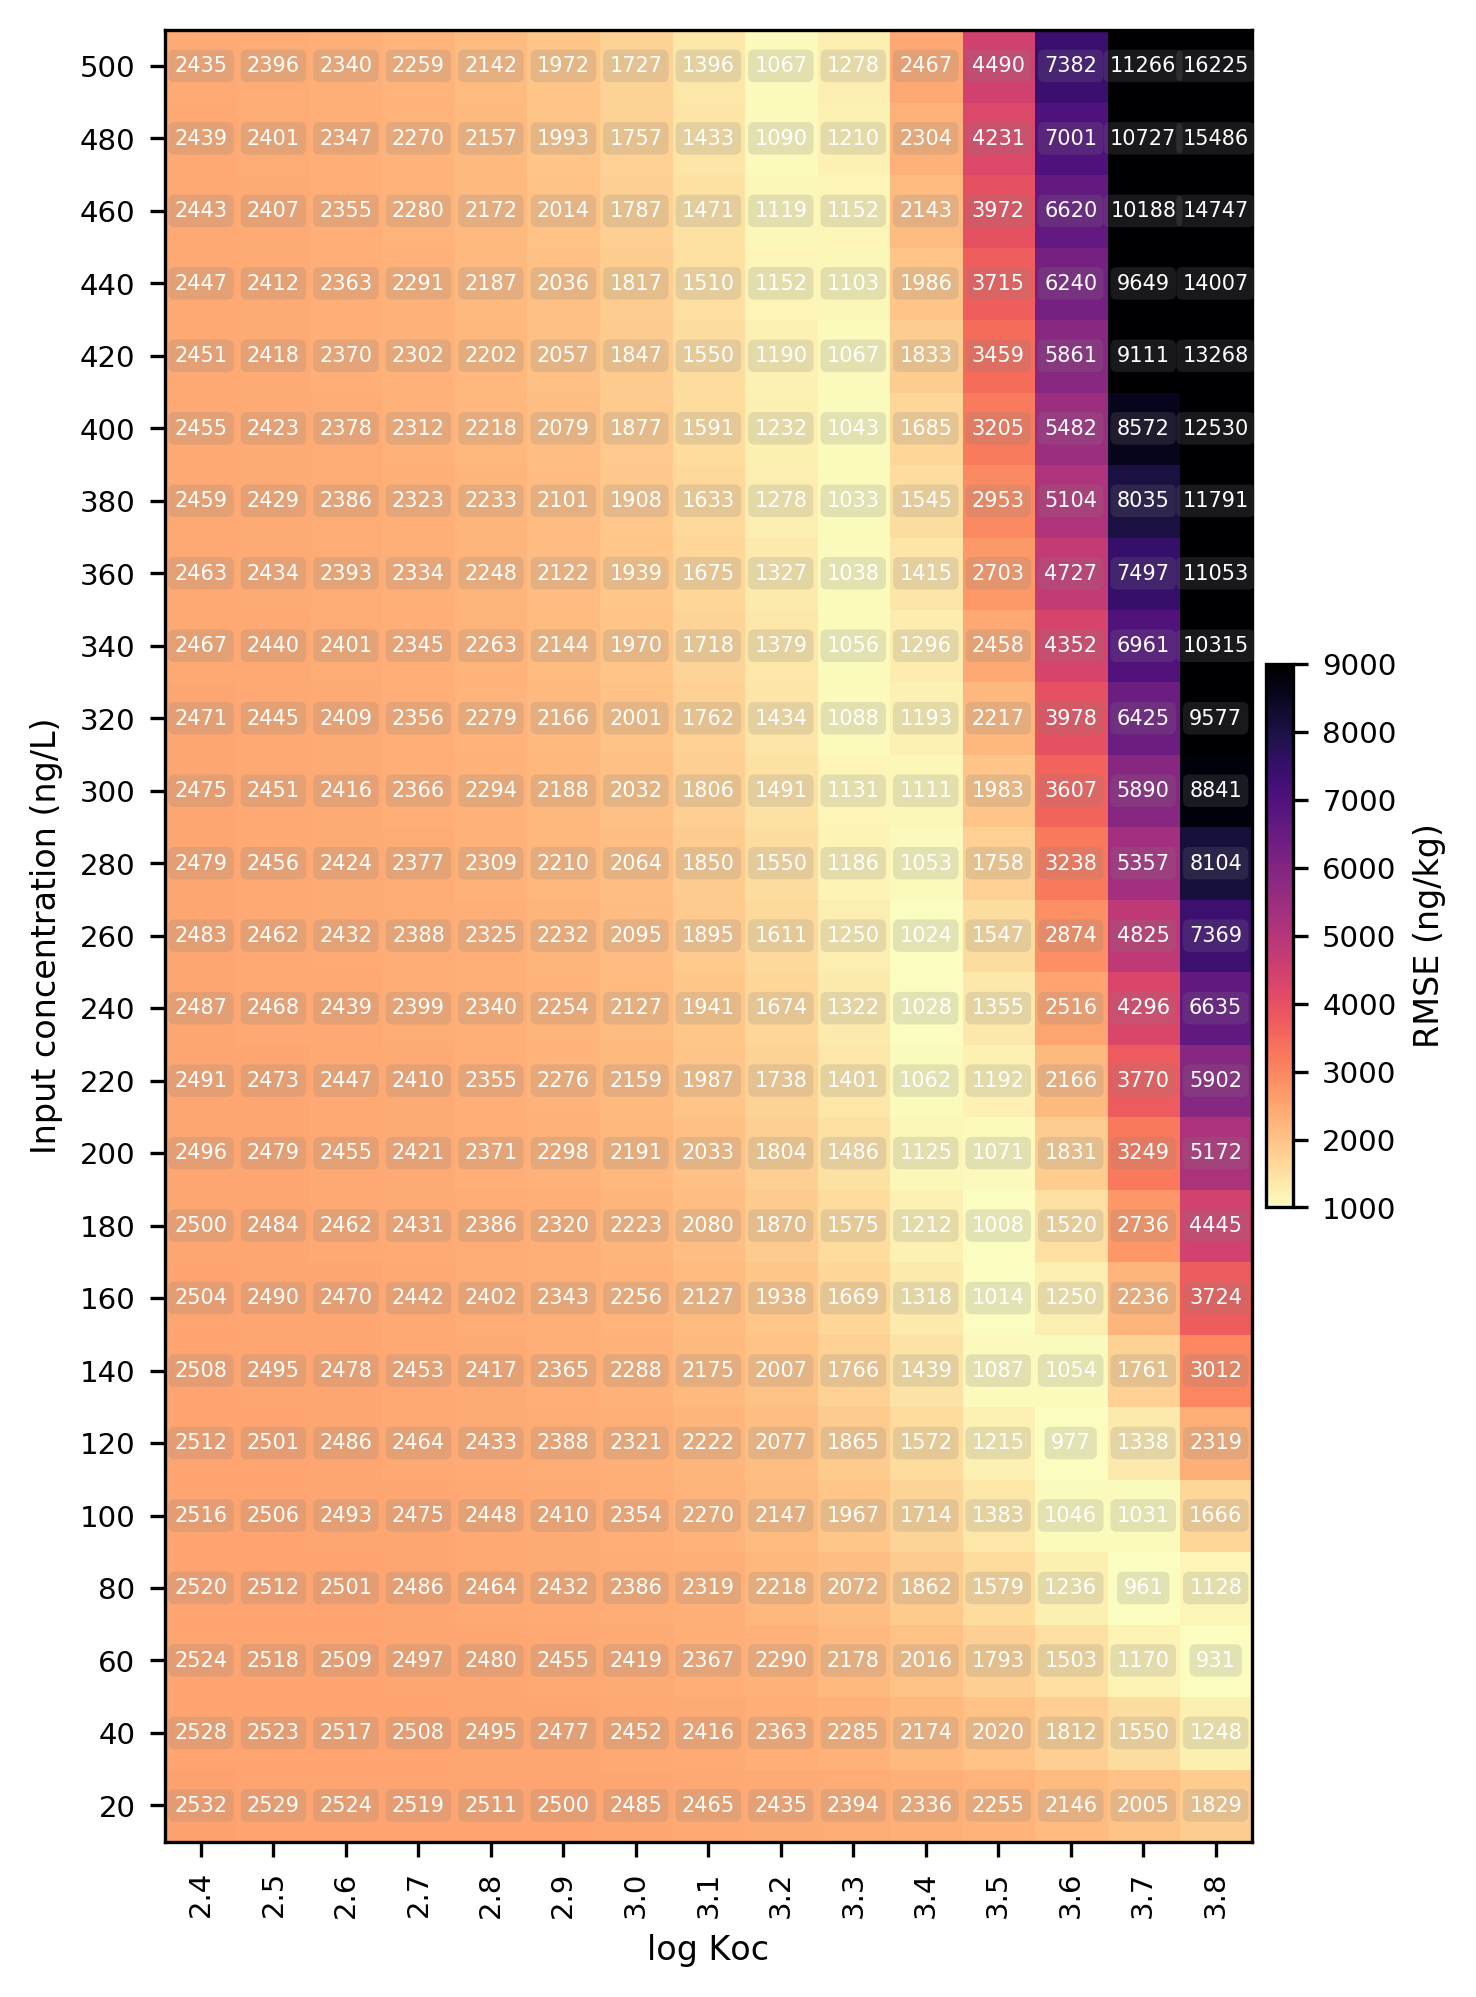

In [19]:
rms_piv = rms_df.pivot(columns='logKoc',index='con_in',values='rms')
rms_piv.columns = rms_piv.columns.values.round(2)
display_cons = np.arange(20.,510.,20.)
display_koc = np.arange(2.4,3.85,.1).round(2)
rms_piv = rms_piv.loc[display_cons,display_koc]

fig, ax = plt.subplots(figsize=(6,8),dpi=300)
im = ax.imshow((rms_piv.values),cmap='magma_r',aspect='equal',
               vmin=1000,vmax=9000
              )

ax.set_xticks(np.arange(len(rms_piv.columns)))
ax.set_yticks(np.arange(len(rms_piv.index)))

ax.set_xticklabels(rms_piv.columns.values.round(2),rotation=90)
ax.set_yticklabels(int(x) for x in rms_piv.index.values)
ax.set_ylabel('Input concentration (ng/L)')
ax.set_xlabel('log Koc')
ax.invert_yaxis()

cb = fig.colorbar(im,ax=ax,shrink=0.3,pad=0.01,label='RMSE (ng/kg)')

bbox = dict(boxstyle="round", fc="gray",lw='0',alpha=.2)
for i,k in enumerate(rms_piv.index):
    for j,c in enumerate(rms_piv.columns):
        if np.isnan(rms_piv.loc[k, c]) == False:
            ax.annotate('{:.0f}'.format(rms_piv.loc[k, c]), (j, i),fontsize=5, 
                           ha='center', va='center', color='w',bbox=bbox)
fig.patch.set_facecolor('w')

## Time Series

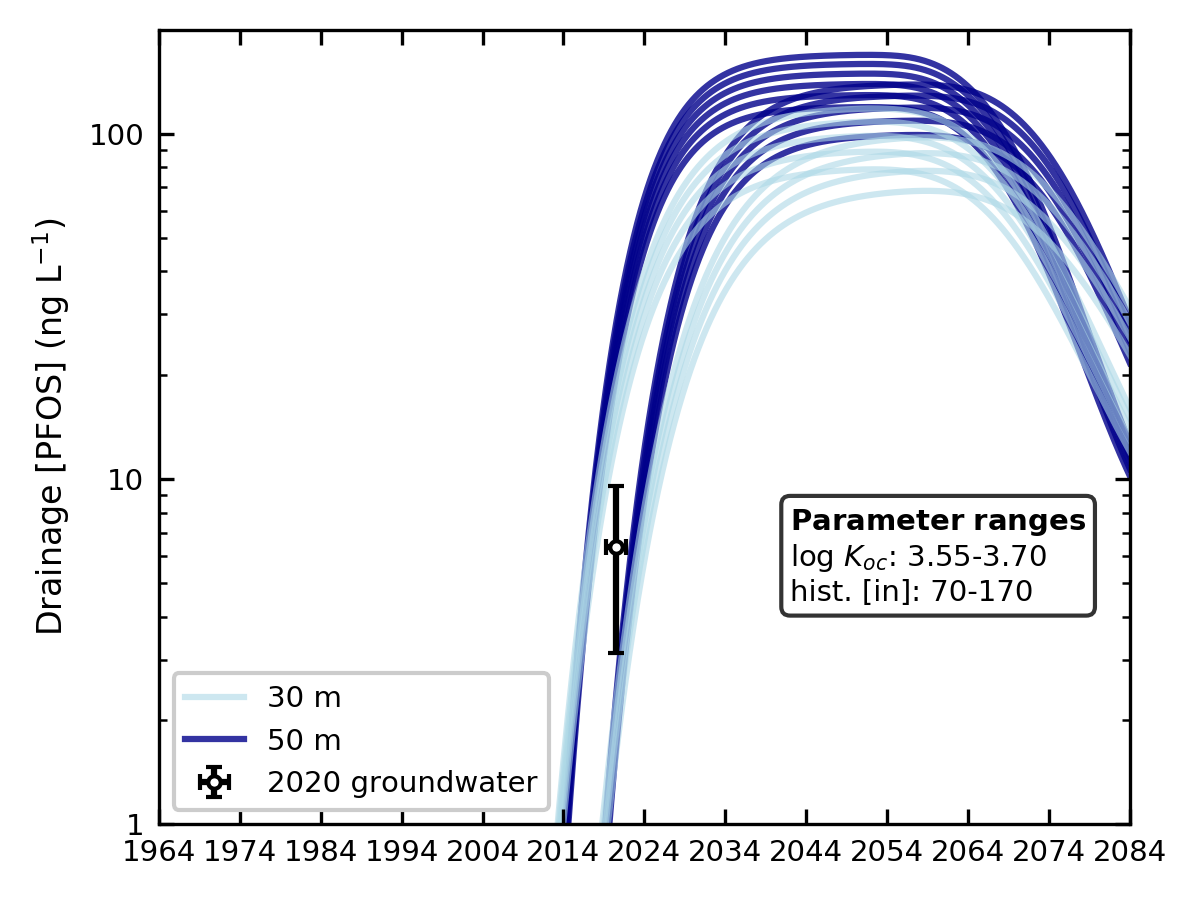

In [14]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,6241,1.) # this is for 
# time = 

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

#------------------------------------------------
# linear drop between 2000-2014
# plot best rms results
best_keys_30s = rms_df[
                    ((rms_df['logKoc'].round(2) == 3.65)|
                     (rms_df['logKoc'].round(2) == 3.7)) &
                    (rms_df['rms'] < 1100)].index.values
best_keys_50s = rms_df[
                    ((rms_df['logKoc'].round(2) == 3.55)|
                     (rms_df['logKoc'].round(2) == 3.6)) &
                    (rms_df['rms'] < 1100)
                    ].index.values


for i,key in enumerate(best_keys_30s):
    thirty = thirty_df[key]
    if i == 0:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1, label='30 m')
    else:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1)
        
for i,key in enumerate(best_keys_50s):
    bottom = bottom_df[key]
    if i == 0:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1, label='50 m')
    else:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1)

# manually make the label
key = best_keys_30[-1]
thirty = thirty_df[key]
vals = key.split('_')
second = best_keys_30[0].split('_')
ax.annotate('$\mathbf{{Parameter}}$ $\mathbf{{ranges}}$\nlog $K_{oc}$: 3.55-3.70\nhist. [in]: 70-170',xycoords='axes fraction',
            xy=(.65,.4),bbox=bbox,va='top',ha='left')

#------------------------------------------------
# make pretty
ax.set_xlim(0,120*52)
ax.set_xticks([x*52 for x in np.arange(0,130,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2094,10)]);

ax.errorbar([56.5*52],[gw_stats.loc['PFOS','mean']],
            yerr=[gw_stats.loc['PFOS','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)



ax.set_ylabel('Drainage [PFOS] (ng L$^{-1}$)')
ax.set_yscale('log')
ax.set_ylim(1,200)
ax.yaxis.set_major_formatter(ScalarFormatter())

ax.tick_params(which='both',direction='in',right=True,top=True)
ax.legend(loc='lower left',framealpha=1)
fig.tight_layout()
# fig.savefig('./figs/pfos_time_series_to_2084.png')

## Profile

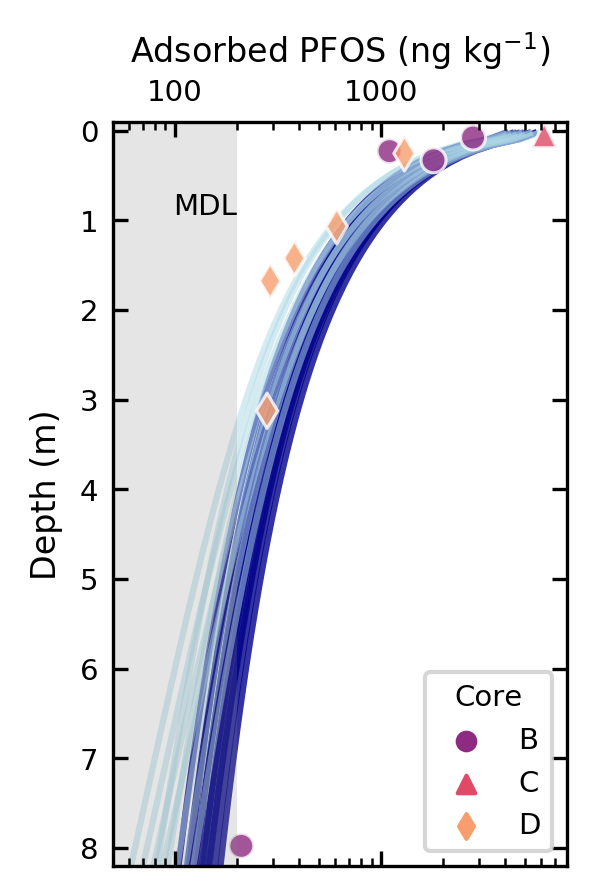

In [16]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOS',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D2A81','#DF4A69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)

low = .1
high = .9
number_of_lines= 1
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap('viridis_r')
colors = [ cmap(x) for x in cm_subsection ]

    
for key in best_keys_30s:
    ax.plot(ads_dict5s[key].loc[:,2601].values,ads_dict5s[key].loc[:,2601].index.values,'-',c='lightblue',alpha=.5,
           zorder=-1)
    
for key in best_keys_50s:
    ax.plot(ads_dict5s[key].loc[:,2601].values,ads_dict5s[key].loc[:,2601].index.values,'-',c='darkblue',alpha=.8,
           zorder=-2)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='lower right',markerscale=.7, title='Core')


ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOS (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')

ax.annotate('', xy=(.95,.7), xycoords='axes fraction', fontsize=12,ha='right');

ax.set_xscale('log')
ax.set_xlim(50,8000)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(8.2,-.1)

ax.axvspan(10,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(.2*1000,1),va='bottom',ha='right')
fig.tight_layout()
# fig.savefig('./figs/pfos_profile_final.png')

## Faster flow scenarios

### Run example models

In [17]:
# 5. "daily" timestep, faster flowthrough
pfaa = 'PFOS'
con_mean = eff_stats.loc[pfaa,'mean']

koc5 = 10**3.65
kd = focs * koc5
con_in5 = 75

# add the false spacers to the daily timestep
line = list(np.linspace(con_in5 * V * 1000,con_mean * V * 1000,14*52))
down = []
for x in line:
    down+=[x]+[False]*6

# sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + ([con_mean * V * 1000]+[False]*6)*63*52
sol_mass_in = ([con_in5 * V * 1000]+[False]*6)*37*52 + down + ([con_mean * V * 1000]+[False]*6)*49*52
#                 + ([(con_in/2) * V * 1000]+[False]*6)*14*52\
                
ads5, sol5 = bucket_day(sol_mass_in,kd,soil_masses,pfaa)

thirty_df5 = sol5.iloc[370,:].values
bottom_df5 = sol5.iloc[-1,:].values

In [18]:
# 6. "daily" timestep, faster flowthroughb
pfaa = 'PFOS'
con_mean = eff_stats.loc[pfaa,'mean']

koc6 = 10**3.7
kd = focs * koc6
con_in6 = 75

# add the false spacers to the daily timestep
line = list(np.linspace(con_in6 * V * 1000,con_mean * V * 1000,14*52))
down = []
for x in line:
    down+=[x]+[False]*6

# sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + ([con_mean * V * 1000]+[False]*6)*63*52
sol_mass_in = ([con_in6 * V * 1000]+[False]*6)*37*52 + down + ([con_mean * V * 1000]+[False]*6)*49*52
#                 + ([(con_in/2) * V * 1000]+[False]*6)*14*52\
                
ads6, sol6 = bucket_day(sol_mass_in,kd,soil_masses,pfaa)

thirty_df6 = sol6.iloc[370,:].values
bottom_df6 = sol6.iloc[-1,:].values

### time series

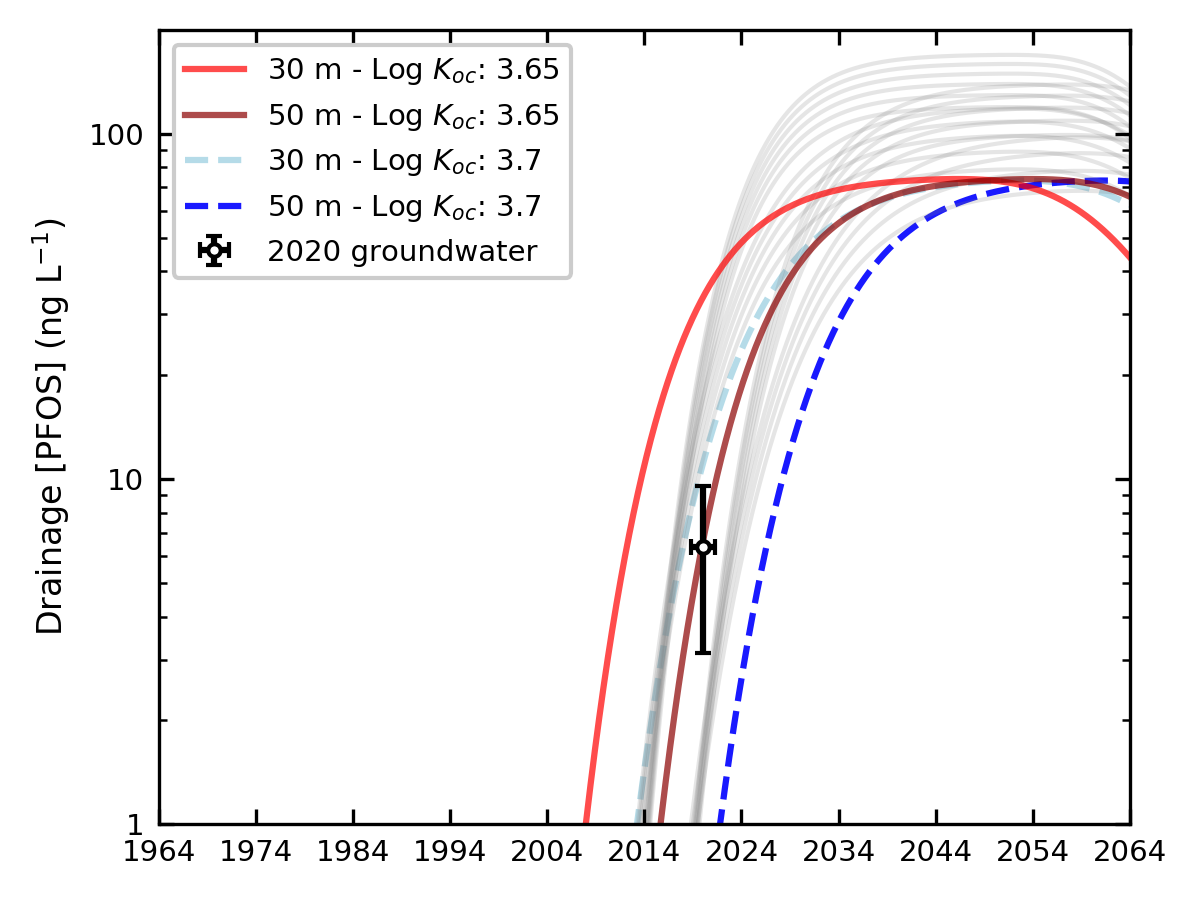

In [19]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,5201,1.)

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

thi_day = sol5.loc[sol5.index[370],np.arange(7,sol5.columns[-1]+1,7)].values
bot_day = sol5.loc[sol5.index[-1],np.arange(1,sol5.columns[-1]+1,7)].values
ax.plot(time,thi_day,alpha=.7,zorder=1,c='red',ls='-',
#         label='30 m'
        label='30 m - Log $K_{{oc}}$: {}'.format(np.log10(koc5))
       )
ax.plot(time,bot_day,alpha=.7,zorder=1,c='darkred',ls='-',
#         label='50 m'
        label='50 m - Log $K_{{oc}}$: {}'.format(np.log10(koc5))
       )

thi_day = sol6.loc[sol6.index[370],np.arange(7,sol6.columns[-1]+1,7)].values
bot_day = sol6.loc[sol6.index[-1],np.arange(1,sol6.columns[-1]+1,7)].values
ax.plot(time,thi_day,alpha=.9,zorder=-1,c='lightblue',ls='--',
        label='30 m - Log $K_{{oc}}$: {}'.format(np.log10(koc6)))
ax.plot(time,bot_day,alpha=.9,zorder=-1,c='blue',ls='--',
        label='50 m - Log $K_{{oc}}$: {}'.format(np.log10(koc6)))

#------------------------------------------
# 2001 transition
# plot best rms results

for i,key in enumerate(best_keys_30):
    thirty = thirty_df[key]
    ax.plot(time,thirty[:5200],'-',alpha=.2,lw=1,c='gray',zorder=-1)
        
for i,key in enumerate(best_keys_50):
    bottom = bottom_df[key]
    ax.plot(time,bottom[:5200],'-',alpha=.2,lw=1,c='gray',zorder=-1)

#---------------------------
# make pretty

# ax.annotate('log $K_{{oc}}$: {}\nhist. [in]: {}'.format(np.log10(koc5), con_in5),xycoords='axes fraction',
#             xy=(.25,.4),bbox=bbox,va='top',ha='left')

ax.set_xlim(0,100*52)
ax.set_xticks([x*52 for x in np.arange(0,110,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2074,10)]);

ax.errorbar([56*52],[gw_stats.loc['PFOS','mean']],
            yerr=[gw_stats.loc['PFOS','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)


ax.set_ylabel('Drainage [PFOS] (ng L$^{-1}$)')
# ax.set_ylim(-1,80)
ax.set_yscale('log')
ax.set_ylim(10**0,200)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(which='both',direction='in',right=True,top=True)
# ax.tick_params(axis='x',labelrotation=90)
ax.legend(loc='best',framealpha=1,ncol=1)
fig.patch.set_facecolor('w')
fig.tight_layout()
# fig.savefig('./figs/pfos_time_series_scenarios.png')

### Profile

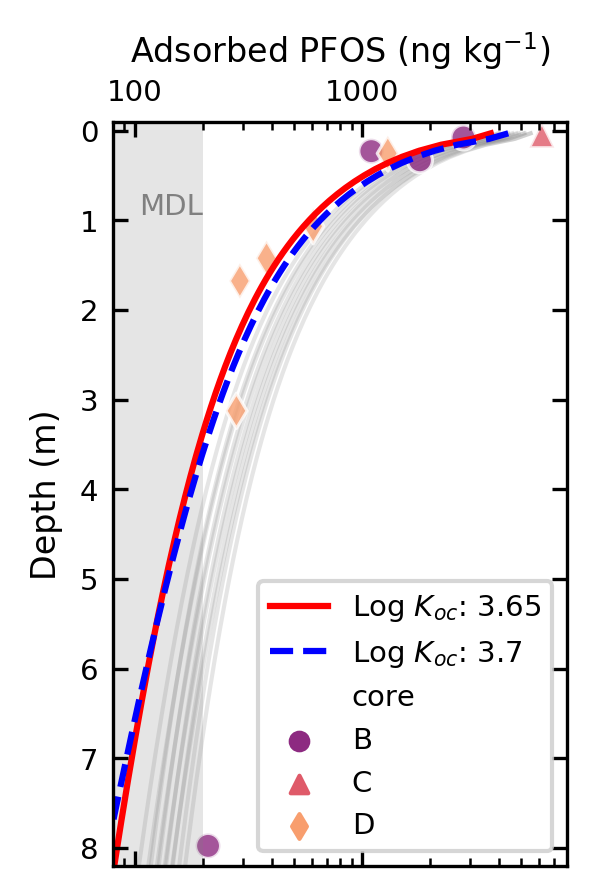

In [20]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOS',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D2A81','#DF5a69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)

for key in best_keys_50:
    ax.plot(ads_dict5s[key].loc[:,2601].values,ads_dict5s[key].loc[:,2601].index.values,
            alpha=.2,c='gray',lw=1,zorder=-1)
    
ax.plot(ads5.loc[:,2601*7].values,ads5.loc[:,2601*7].index.values,'-',alpha=1,c='r',zorder=1,
        label='Log $K_{{oc}}$: {}'.format(np.log10(koc5)))
ax.plot(ads6.loc[:,2601*7].values,ads6.loc[:,2601*7].index.values,'--',alpha=1,c='b',zorder=1,
        label='Log $K_{{oc}}$: {}'.format(np.log10(koc6)))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:], labels[:], loc='lower right',markerscale=.7)

ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOS (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')


ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim(80,8000)
ax.set_ylim(8.2,-.1)

ax.axvspan(.01,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(.2*1000,1),color='gray',va='bottom',ha='right')
fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig('./figs/pfos_profile_scenarios.png')

# PFOA

## Run parameter sweep

In [25]:
run = False
if run:
    pfaa = 'PFOA'
    con_mean = eff_stats.loc[pfaa,'mean']

    logkoc_range = list(np.arange(1.9,2.8,.1))
    con_range = list(np.arange(10.,510.,10.))+list(np.arange(600.,3100.,100.))
    # 0 in pairs is logkoc and 1 is input concentration
    pairs = list(itertools.product(logkoc_range, con_range))
    keys = ['{:.1f}_{:.0f}'.format(p[0],p[1]) for p in pairs]

    bot_dict = {}
    thi_dict = {}
    rms_list = []

    for p, k in zip(pairs,keys):
        koc = 10**p[0]
        kd = focs * koc
    #     sol_mass_in = [p[1] * V * 1000 for x in range(41*52)]+[con_mean * V * 1000 for x in range(59*52)]
        sol_mass_in = [p[1] * V * 1000]*37*52 \
                    + list(np.linspace(p[1] * V * 1000,con_mean * V * 1000,14*52))\
                    + [con_mean * V * 1000]*49*52 
        ads, sol, rms = bucket(sol_mass_in,kd,soil_masses,pfaa)

        thi_dict[k] = sol.iloc[370,:].values
        bot_dict[k] = sol.iloc[-1,:].values

    #     ads_dict[k] = ads
    #     sol_dict[k] = sol
        # save pared down versions of the output
        ads.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfoa_sweep/ads5/'+k+'.csv')
        sol.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfoa_sweep/sol5/'+k+'.csv')

        rms_list.append([k,p[0],p[1],rms])

        print(k, datetime.now())

    bottom_df = pd.DataFrame(bot_dict)
    bottom_df.to_csv('./pfoa_sweep/bottom_v5.csv')
    thirty_df = pd.DataFrame(thi_dict)
    thirty_df.to_csv('./pfoa_sweep/thirty_v5.csv')

    rms_df = pd.DataFrame(rms_list,columns = ['key','logKoc','con_in','rms'])
    rms_df.to_csv('./pfoa_sweep/rms_v5.csv')

    del bottom_df, thirty_df, rms_df, bot_dict, thi_dict, rms_list

## Retrieve data from csv files if sweep has been run in the past

In [31]:
ads_dict5a = {}
sol_dict5a = {}

for csv in os.listdir('./pfoa_sweep/ads5'):
    key = os.path.splitext(csv)[0]
    a = pd.read_csv('./pfoa_sweep/ads5/'+csv,index_col='Unnamed: 0')
    a.columns = [int(x) for x in a.columns.values]
    s = pd.read_csv('./pfoa_sweep/sol5/'+csv,index_col='Unnamed: 0')
    s.columns = [int(x) for x in s.columns.values]
    ads_dict5a[key] = a
    sol_dict5a[key] = s

bottom_df5a = pd.read_csv('./pfoa_sweep/bottom_v5.csv')
thirty_df5a = pd.read_csv('./pfoa_sweep/thirty_v5.csv')
rms_df5a = pd.read_csv('./pfoa_sweep/rms_v5.csv')
rms_drop5a = rms_df5a.copy()
rms_drop5a.sort_values(by=['logKoc','con_in'],inplace=True)
rms_drop5a.set_index('key',inplace=True)

## heatmap

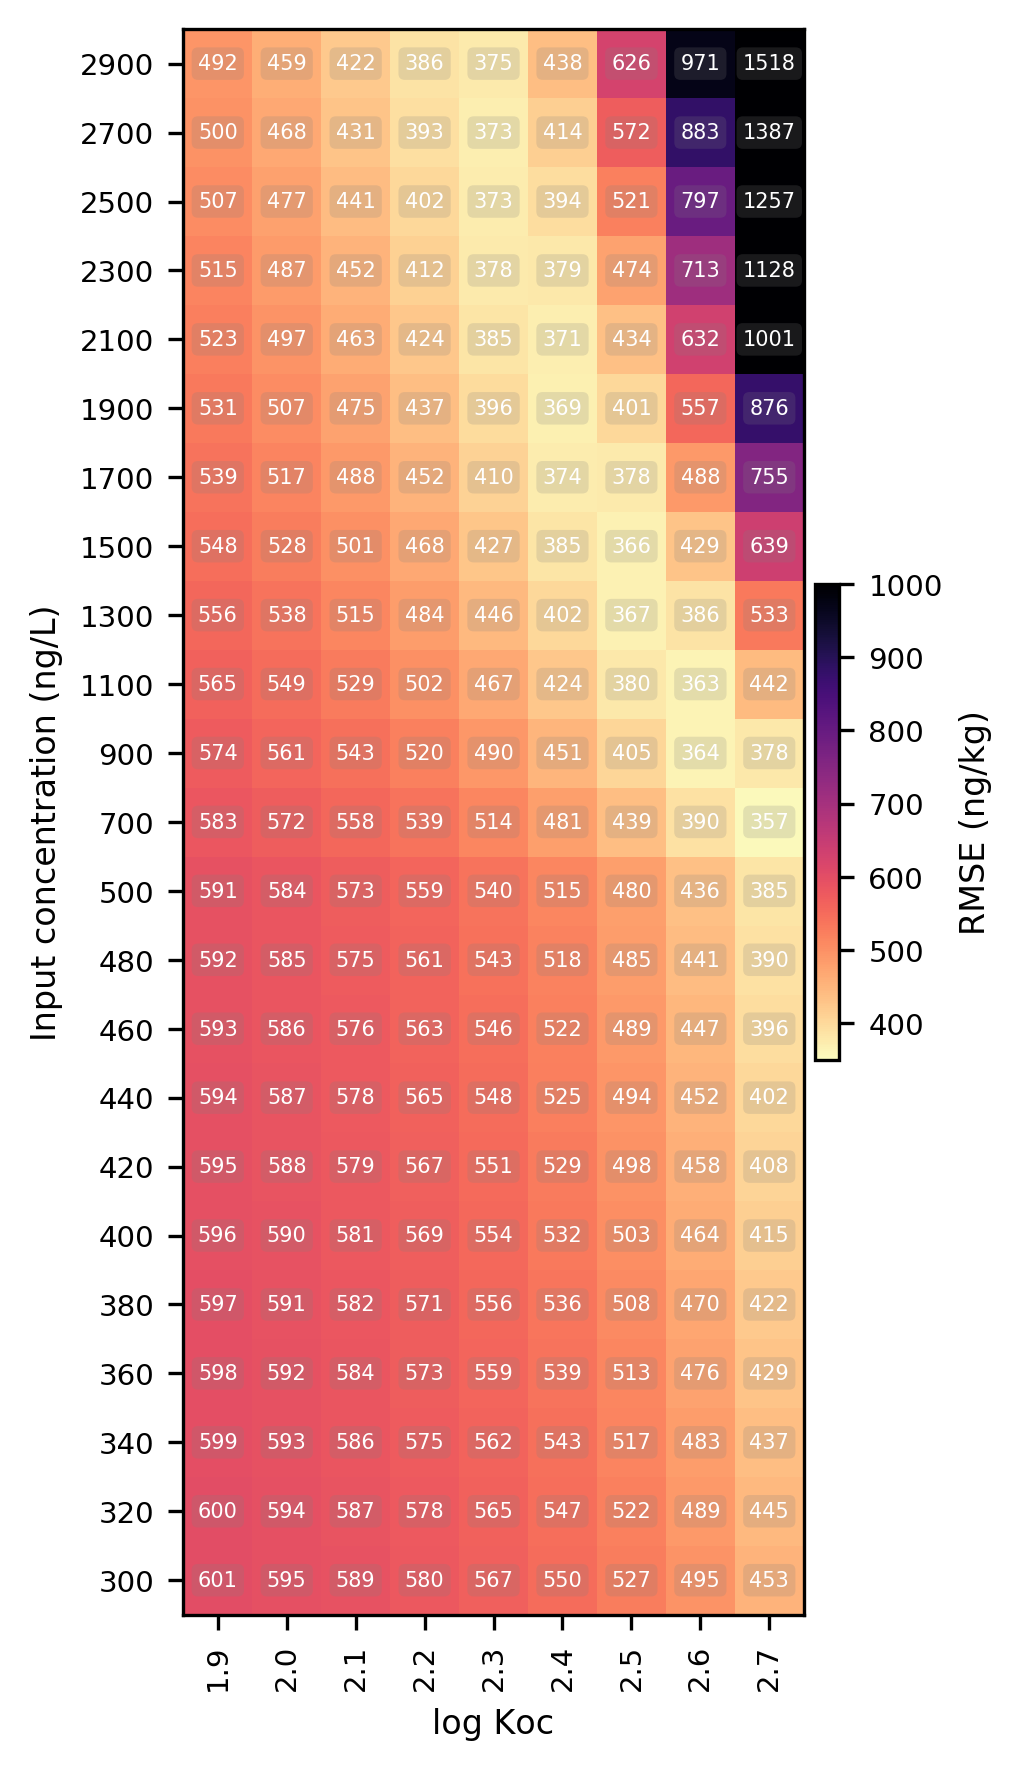

In [33]:
rms_piv = rms_drop5a.pivot(columns='logKoc',index='con_in',values='rms')
# display_cons = np.arange(20.,10.,20.)
display_logkoc = np.arange(1.9,2.8,.1)
rms_piv = rms_piv.iloc[range(29,len(rms_piv),2),:]
# df = rms_piv.loc[]

fig, ax = plt.subplots(figsize=(5,7),dpi=300)
im = ax.imshow((rms_piv.values),cmap='magma_r',aspect='equal',
               vmin=350,vmax=1000
#                norm=colors.LogNorm()
              )

ax.set_xticks(np.arange(len(rms_piv.columns)))
ax.set_yticks(np.arange(len(rms_piv.index)))

# ax.set_xticklabels(int(x) for x in rms_piv.columns.values)
# ax.set_yticklabels(rms_piv.index.values.round(1))
ax.set_xticklabels(rms_piv.columns.values.round(2),rotation=90)
ax.set_yticklabels(int(x) for x in rms_piv.index.values)
ax.set_ylabel('Input concentration (ng/L)')
ax.set_xlabel('log Koc')
ax.invert_yaxis()

cb = fig.colorbar(im,ax=ax,shrink=0.3,pad=0.01,label='RMSE (ng/kg)')
# cb.ax.get_yaxis().set_ticklabels(np.arange(1.5,5,.5))
# cb.ax.set_title('x1000',ha='left',fontsize=6)
# cb.ax.xaxis.set_major_formatter(ScalarFormatter())

bbox = dict(boxstyle="round", fc="gray",lw='0',alpha=.2)
for i,k in enumerate(rms_piv.index):
    for j,c in enumerate(rms_piv.columns):
        if np.isnan(rms_piv.loc[k, c]) == False:
            ax.annotate('{:.0f}'.format(rms_piv.loc[k, c]), (j, i),fontsize=5, 
                           ha='center', va='center', color='w',bbox=bbox)
# fig.tight_layout()
fig.patch.set_facecolor('w')

## Time series

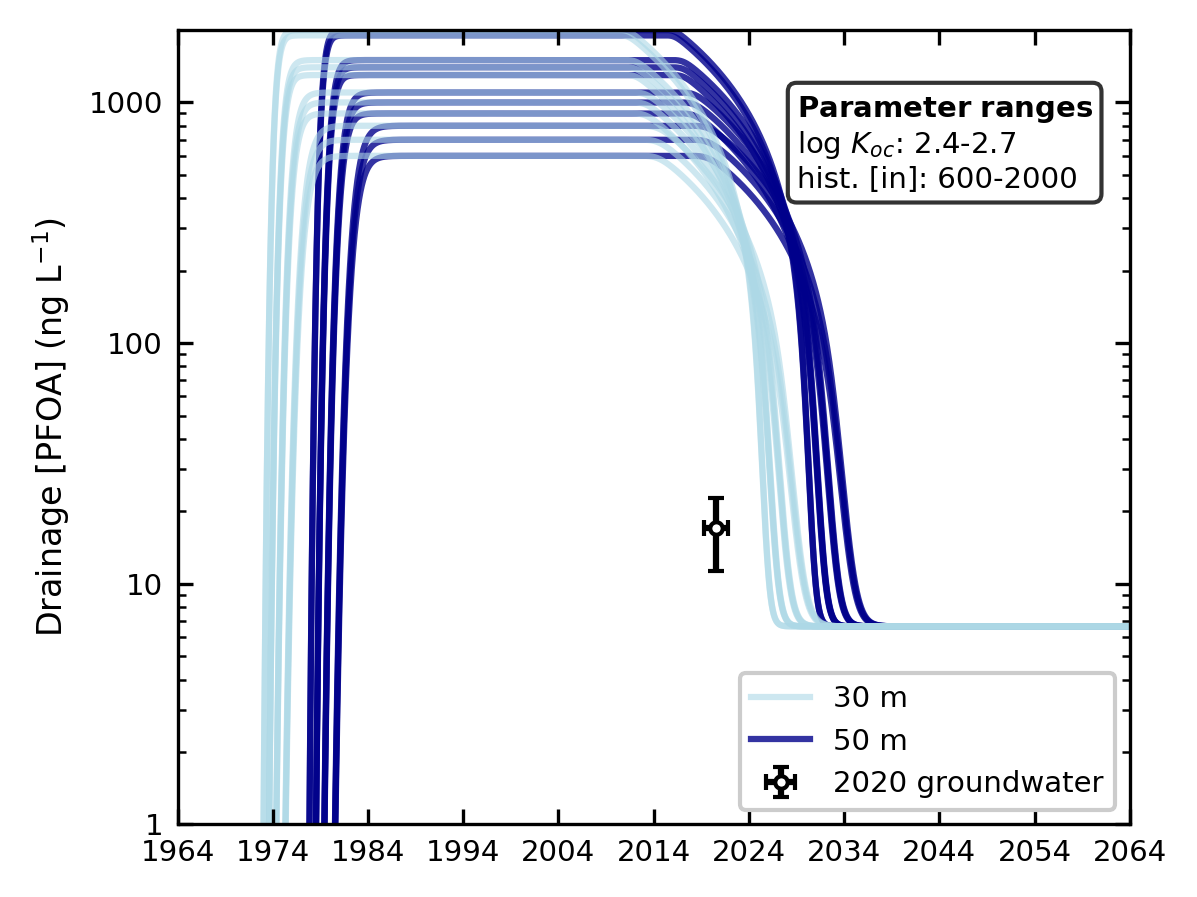

In [35]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,5201,1.)

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

#------------------------------------------
# linear transition
# plot best rms results
best_keys_30_5a = rms_drop5a[
#                     (rms_drop5a['con_in'] >= 20.) &
#                     (rms_drop5a['con_in'] <= 150.) &
                    (rms_drop5a['logKoc'].round(1) <= 2.7) &
                    (rms_drop5a['rms'] < 370)
                    ].index.values
best_keys_50_5a = rms_drop5a[
#                     (rms_drop5a['con_in'] == 20.) &
#                     ((rms_drop5a['logKoc'].round(1) == 2.6) |
                    (rms_drop5a['logKoc'].round(1) <= 2.7) &
                    (rms_drop5a['rms'] < 370)
                    ].index.values

for i,key in enumerate(best_keys_30_5a):
    thirty = thirty_df5a[key]
    if i == 0:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1, label='30 m')
    else:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1)
        
for i,key in enumerate(best_keys_50_5a):
    bottom = bottom_df5a[key]
    if i == 0:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1, label='50 m')
    else:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1)

key = best_keys_30_5a[-1]
thirty = thirty_df5a[key]
vals = key.split('_')
second = best_keys_30_5a[0].split('_')
ax.annotate('$\mathbf{{Parameter}}$ $\mathbf{{ranges}}$\nlog $K_{oc}$: 2.4-2.7\nhist. [in]: 600-2000',
            (.65,.92),xycoords='axes fraction',bbox=bbox,va='top',ha='left')

#---------------------------
# make pretty

# ax.axvline(37*52,ls='-',c='r')
# ax.axvline(41*52,ls='--',c='r')

ax.set_xlim(0,100*52)
ax.set_xticks([x*52 for x in np.arange(0,110,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2074,10)]);

ax.errorbar([56.5*52],[gw_stats.loc['PFOA','mean']],
            yerr=[gw_stats.loc['PFOA','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)


ax.set_ylabel('Drainage [PFOA] (ng L$^{-1}$)')
# ax.set_ylim(-1,80)
ax.set_yscale('log')
ax.set_ylim(10**0,2000)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(which='both',direction='in',right=True,top=True)
# ax.tick_params(axis='x',labelrotation=90)
ax.legend(loc='lower right',framealpha=1)
# fig.patch.set_facecolor('w')
fig.tight_layout()
# fig.savefig('./figs/pfoa_time_series_final.png')

## Profile

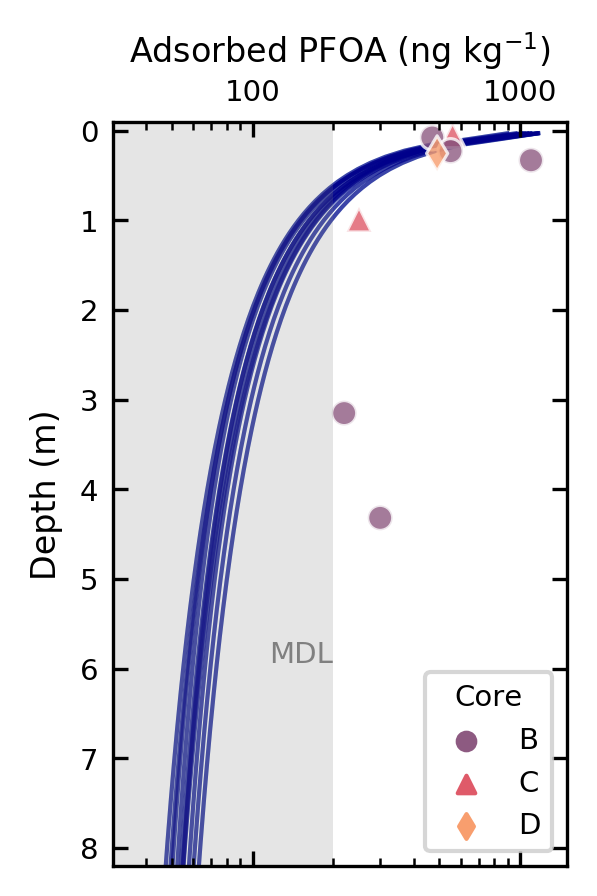

In [39]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOA',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D5a81','#DF5a69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)
low = .1
high = .9
number_of_lines = 1
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap('viridis_r')
colors = [ cmap(x) for x in cm_subsection ]

for key in best_keys_30_5a:
    ax.plot(ads_dict5a[key].loc[:,2601].values,ads_dict5a[key].loc[:,2601].index.values,'-',c='lightblue',alpha=.7,
           zorder=-1,lw=1)
    
for key in best_keys_50_5a:
    ax.plot(ads_dict5a[key].loc[:,2601].values,ads_dict5a[key].loc[:,2601].index.values,'-',c='darkblue',alpha=.7,
           zorder=-1,lw=1)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='lower right',markerscale=.7, title='Core')


ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOA (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')

ax.annotate('', xy=(.95,.7), xycoords='axes fraction', fontsize=12,ha='right');

ax.set_xscale('log')
ax.set_xlim(30,1500)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(8.2,-.1)

ax.axvspan(1,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(200,6),color='gray',va='bottom',ha='right')
fig.tight_layout()
# fig.patch.set_facecolor('w')
# fig.savefig('./figs/pfoa_profile_final.png')

## Faster flow scenarios

### Run example models

In [40]:
# 5. "daily" timestep, faster flowthrough
pfaa = 'PFOA'
con_mean = eff_stats.loc[pfaa,'mean']

koc = 10**2.5
kd = focs * koc
con_in = 1000

# add the false spacers to the daily timestep
line = list(np.linspace(con_in * V * 1000,con_mean * V * 1000,14*52))
down = []
for x in line:
    down+=[x]+[False]*6

# sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + ([con_mean * V * 1000]+[False]*6)*63*52
sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + down + ([con_mean * V * 1000]+[False]*6)*49*52
#                 + ([(con_in/2) * V * 1000]+[False]*6)*14*52\
                
ads5, sol5 = bucket_day(sol_mass_in,kd,soil_masses,pfaa)

thirty_df5 = sol5.iloc[370,:].values
bottom_df5 = sol5.iloc[-1,:].values

In [41]:
# 6. "daily" timestep, faster flowthrough
pfaa = 'PFOA'
con_mean = eff_stats.loc[pfaa,'mean']

koc = 10**2.4
kd = focs * koc
con_in = 1300

# add the false spacers to the daily timestep
line = list(np.linspace(con_in * V * 1000,con_mean * V * 1000,14*52))
down = []
for x in line:
    down+=[x]+[False]*6

# sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + ([con_mean * V * 1000]+[False]*6)*63*52
sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + down + ([con_mean * V * 1000]+[False]*6)*49*52
#                 + ([(con_in/2) * V * 1000]+[False]*6)*14*52\
                
ads6, sol6 = bucket_day(sol_mass_in,kd,soil_masses,pfaa)

thirty_df6 = sol5.iloc[370,:].values
bottom_df6 = sol5.iloc[-1,:].values

### time series

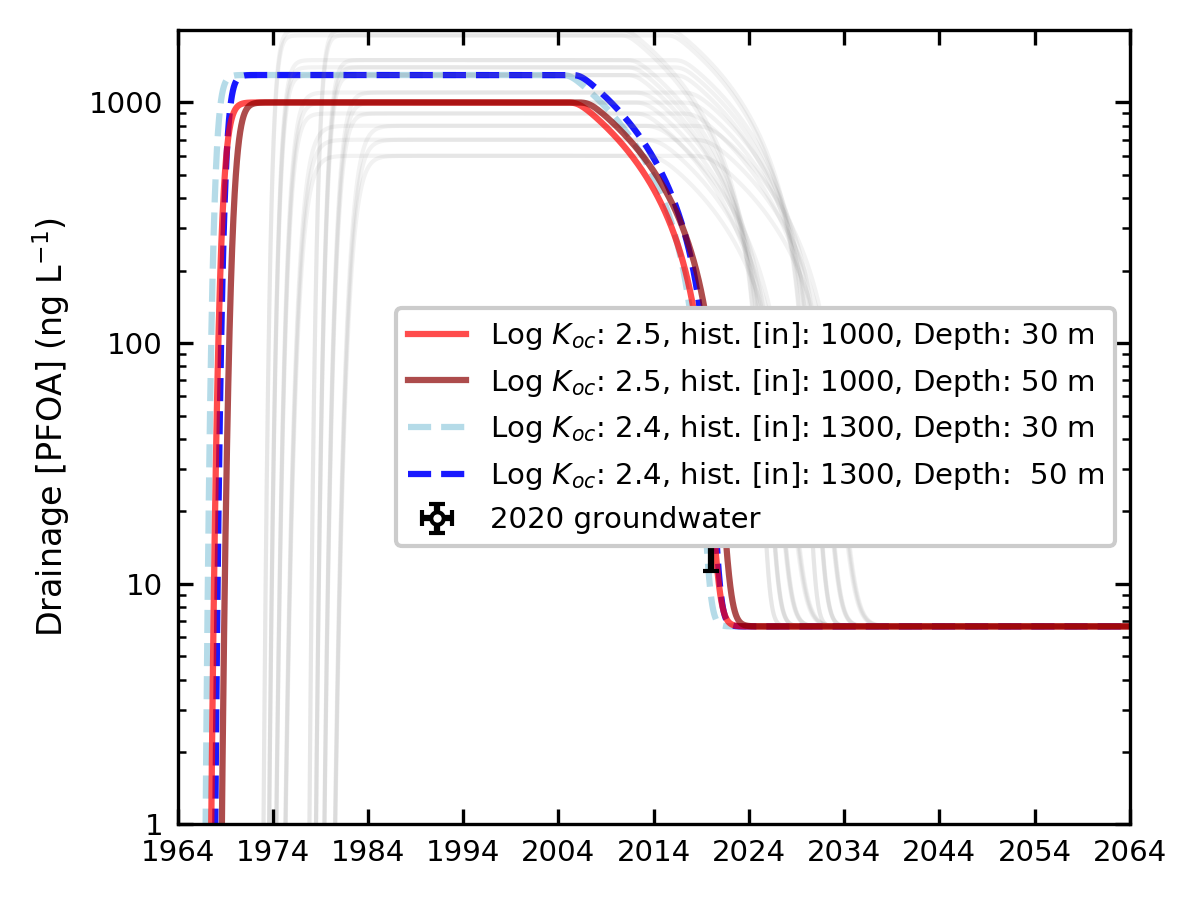

In [42]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,5201,1.)

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

thi_day = sol5.loc[sol5.index[370],np.arange(7,sol5.columns[-1]+1,7)].values
bot_day = sol5.loc[sol5.index[-1],np.arange(1,sol5.columns[-1]+1,7)].values
ax.plot(time,thi_day,alpha=.7,zorder=1,c='red',ls='-',label='Log $K_{oc}$: 2.5, hist. [in]: 1000, Depth: 30 m')
ax.plot(time,bot_day,alpha=.7,zorder=1,c='darkred',ls='-',label='Log $K_{oc}$: 2.5, hist. [in]: 1000, Depth: 50 m')

thi_day = sol6.loc[sol6.index[370],np.arange(7,sol6.columns[-1]+1,7)].values
bot_day = sol6.loc[sol6.index[-1],np.arange(1,sol6.columns[-1]+1,7)].values
ax.plot(time,thi_day,alpha=.9,zorder=-1,c='lightblue',ls='--',label='Log $K_{oc}$: 2.4, hist. [in]: 1300, Depth: 30 m')
ax.plot(time,bot_day,alpha=.9,zorder=-1,c='blue',ls='--',label='Log $K_{oc}$: 2.4, hist. [in]: 1300, Depth:  50 m')

#------------------------------------------
# 2001 transition
# plot best rms results

for i,key in enumerate(best_keys_30_5a):
    thirty = thirty_df5a[key]
    ax.plot(time,thirty,'-',alpha=.1,lw=1,c='gray',zorder=-1)
        
for i,key in enumerate(best_keys_50_5a):
    bottom = bottom_df5a[key]
    ax.plot(time,bottom,'-',alpha=.1,lw=1,c='gray',zorder=-1)

#---------------------------
# make pretty

ax.set_xlim(0,100*52)
ax.set_xticks([x*52 for x in np.arange(0,110,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2074,10)]);

ax.errorbar([56*52],[gw_stats.loc['PFOA','mean']],
            yerr=[gw_stats.loc['PFOA','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)


ax.set_ylabel('Drainage [PFOA] (ng L$^{-1}$)')
# ax.set_ylim(-1,80)
ax.set_yscale('log')
ax.set_ylim(10**0,2000)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(which='both',direction='in',right=True,top=True)
# ax.tick_params(axis='x',labelrotation=90)
ax.legend(loc='best',framealpha=1,ncol=1)
fig.patch.set_facecolor('w')
fig.tight_layout()
fig.savefig('./figs/pfoa_time_series_scenarios2.png')

### Profile

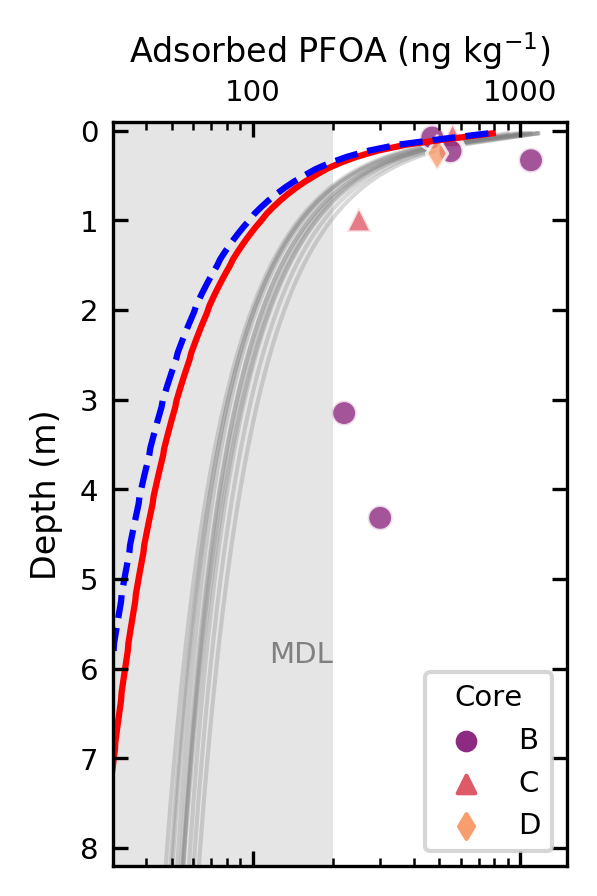

In [43]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOA',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D2A81','#DF5a69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)

for key in best_keys_50_5a:
    ax.plot(ads_dict5a[key].loc[:,2601].values,ads_dict5a[key].loc[:,2601].index.values,
            alpha=.3,c='gray',lw=1,zorder=-1)
    
ax.plot(ads5.loc[:,2601*7].values,ads5.loc[:,2601*7].index.values,'-',alpha=1,c='r',zorder=1)
ax.plot(ads6.loc[:,2601*7].values,ads6.loc[:,2601*7].index.values,'--',alpha=1,c='b',zorder=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='lower right',markerscale=.7, title='Core')

ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOA (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')


ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim(30,1500)
ax.set_ylim(8.2,-.1)

ax.axvspan(.01,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(.2*1000,6),color='gray',va='bottom',ha='right')
fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig('./figs/pfoa_profile_scenarios.png')